### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [81]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

In [82]:
models_results = {'Approach':[], 'precision':[],'recall':[],'f1':[], 'roc_auc':[]} 

labeled samples: 750


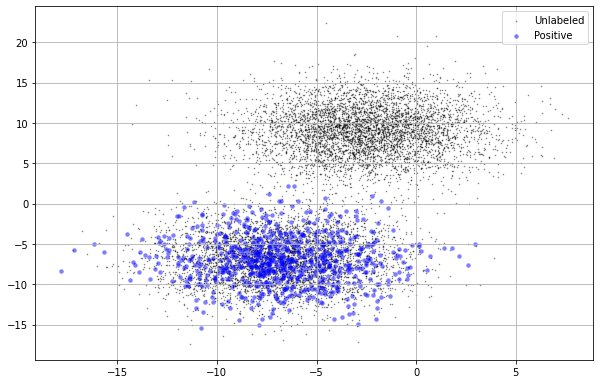

In [83]:
N = 10000
known_labels_ratio = 0.15
X, y = make_blobs(n_samples=N, centers=2, 
                  n_features=4, shuffle=True, 
                  cluster_std=3.0, random_state=42)
rp = np.random.permutation(int(N/2))
data_P = X[y==1][rp[:int(len(rp)*known_labels_ratio)]]
data_U = np.concatenate((X[y==1][rp[int(len(rp)*known_labels_ratio):]], X[y==0]), axis=0)
print("labeled samples: %d" % (data_P.shape[0]))
plt.figure(figsize=(10, 6.5))
plt.scatter(data_U[:, 0], data_U[:, 1], c='k', marker='.', linewidth=1, s=1, alpha=0.5, label='Unlabeled')
plt.scatter(data_P[:, 0], data_P[:, 1], c='b', marker='o', linewidth=0, s=20, alpha=0.5, label='Positive')
plt.grid()
plt.legend()

In [84]:
pd.DataFrame(data_U)

,0,1,2,3
0,-8.465792,-5.118766,-8.357995,9.592457
1,-10.058420,-7.595999,-11.905695,4.064655
2,-5.874002,-3.472487,-7.641836,6.740449
3,-11.058425,-8.666581,-8.979131,2.670172
4,-6.112651,-8.818854,-11.882310,6.700636
...,...,...,...,...
9245,-2.875804,12.645434,4.367116,6.455185
9246,-6.407941,11.503483,7.074068,-1.471620
9247,-3.522445,6.619728,2.443032,0.313367
9248,0.427910,7.084824,0.960197,1.415753


In [85]:
from sklearn.model_selection import train_test_split

X_train, x_test, Y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=7)

In [86]:
import catboost as ctb

model = ctb.CatBoostClassifier(iterations=100,\
                                     max_depth=5, silent = True, random_state=21,\
                                     eval_metric = 'F1')#,\
                                     #reg_lambda=2)
#model = RandomForestClassifier(max_depth=7, n_estimators=400)

model.fit(X_train, Y_train)
y_predict = model.predict(x_test)

In [87]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    
    return prc*100, rec*100, roc*100, f1*100

    
prc_1, rec_1, roc_1, f1_1 = evaluate_results(y_test, y_predict)


Classification results:
f1: 100.00%
roc: 100.00%
recall: 100.00%
precision: 100.00%


In [88]:
models_results['Approach'].append('Begining')
models_results['precision'].append(prc_1)
models_results['recall'].append(rec_1)
models_results['f1'].append(f1_1)
models_results['roc_auc'].append(roc_1)

### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [109]:
mod_data = pd.DataFrame(X.copy())
mod_data['target'] = y
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 30% of the positives marked
pos_sample_len = int(np.ceil(0.2 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 1000/5000 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [110]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    9000
 1    1000
Name: class_test, dtype: int64


* We now have just 4 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

In [111]:
mod_data.head(30)

,0,1,2,3,target,class_test
0,-5.150097,-6.434784,-7.958249,6.242663,1,-1
1,0.897663,5.695406,2.166336,0.147401,0,-1
2,-5.459328,6.157091,3.654219,1.648165,0,-1
3,-14.630185,-5.092982,-8.045574,10.404777,1,-1
4,0.823062,11.279841,7.893311,1.337501,0,-1
5,-7.999282,-8.336470,-13.538722,8.022348,1,-1
6,-0.814605,7.547887,5.263668,3.924639,0,-1
7,1.367684,4.826615,7.658601,4.429895,0,-1
8,-4.743052,-9.780239,-3.036052,8.157839,1,-1
9,-7.386013,-7.536151,-9.078061,2.299876,1,1


Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [112]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(1000, 6) (1000, 6)


In [113]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [114]:
model = RandomForestClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)


In [115]:
prc_2, rec_2, f1_2, roc_2 = evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 99.94%
roc: 99.95%
recall: 99.92%
precision: 99.97%


In [116]:
models_results['Approach'].append('random negative sampling ')
models_results['precision'].append(prc_2)
models_results['recall'].append(rec_2)
models_results['f1'].append(f1_2)
models_results['roc_auc'].append(roc_2)

In [117]:
print(pd.DataFrame(models_results))

                    Approach   precision      recall          f1     roc_auc
0                   Begining  100.000000  100.000000  100.000000  100.000000
1  random negative sampling    99.930724   99.896122   99.923742   99.913420
2  random negative sampling    99.880454  100.000000   99.969961   99.940191
3  random negative sampling    99.971871   99.915659   99.946576   99.943757


Теперь попробуем поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

результаты видим в таблице.

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

2-step approach
